# "Predicting" Stock Market Volatility using Google Trends:

## Relative imports:

In [1]:
import pandas as pd
from pandas_datareader import data as pdr
from datetime import date, datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

%matplotlib inline

## Stock Data:

In [2]:
def SaveData(df, filename):
    df.to_csv(r'data/'+filename+'.csv')
    
def GetData(ticker_list, start_date, end_date):
    print(ticker_list)
    df=[]
    for ticker in ticker_list:
        #print(ticker)
        data = pdr.get_data_yahoo(ticker, start=start_date, end=end_date, progress=False)
        data['Symbol'] = ticker 
        df.append(data)
    print("Data Download Completed")
    return df

def SaveFig(fig_label):
    plt.savefig('fig'+str(fig_label))

### Stocks data from Yahoo Finance using yfinance:

In [3]:
import yfinance as yf
yf.pdr_override()

In [4]:
# Tickers list to download
ticker_list=['NIO','AAPL', 'V', 'BAC', 'NFLX', 'DJI']

# Dates
today = date.today()
start_date = '2020-01-03'
end_date = '2020-05-02'

# Get the Data
df = GetData(ticker_list, start_date, end_date)
df = pd.concat(df)
df = df.reset_index()
df = df[['Date', 'Adj Close', 'Symbol']]
stocks = df.pivot('Date','Symbol','Adj Close').reset_index()

# Saving the data
SaveData(stocks,'stocks-'+str(start_date)+'|'+str(end_date))

['NIO', 'AAPL', 'V', 'BAC', 'NFLX', 'DJI']
Data Download Completed


In [5]:
stocks

Symbol,Date,AAPL,BAC,DJI,NFLX,NIO,V
0,2020-01-02,74.444603,34.709141,NaN,329.809998,3.72,189.950775
1,2020-01-03,73.720840,33.988472,28634.900391,325.899994,3.83,188.440079
2,2020-01-06,74.308266,33.939774,28703.400391,335.829987,3.68,188.032593
3,2020-01-07,73.958794,33.715782,28583.699219,330.750000,3.24,187.535660
4,2020-01-08,75.148521,34.056641,28745.099609,339.260010,3.39,190.745880
...,...,...,...,...,...,...,...
79,2020-04-27,70.352943,23.002846,24133.800781,421.380005,3.24,170.956451
80,2020-04-28,69.212555,23.414486,24101.500000,403.829987,3.34,170.448853
81,2020-04-29,71.485863,24.286774,24633.900391,411.890015,3.61,180.939529
82,2020-04-30,72.993935,23.571302,24345.699219,419.850006,3.41,177.883911


In [6]:
# Calculate daily log returns
daily_returns = np.log(stocks[ticker_list]/stocks[ticker_list].shift(-1))
daily_returns.insert(0, 'Date', stocks['Date'])

# Calculate daily standard deviation of returns
daily_std = np.std(daily_returns)

# Annualized daily standard deviation
std = daily_std * 252 ** 0.5

# Computing an estimate of weekly volatility for log returns
weekly_volatility = daily_returns.rolling(5).std()
weekly_volatility = weekly_volatility.set_index(stocks['Date']).dropna()

---
Since our goal is to predict increase in volatility because of a financial crisis, we should analyze an index rather than a particular stock because we just care about the whole market. Also, one stock could be affected by very specific reasons such as earnings report, news, lawsuits etc. We chose the Dow Jones Industrial Average in this project.

---

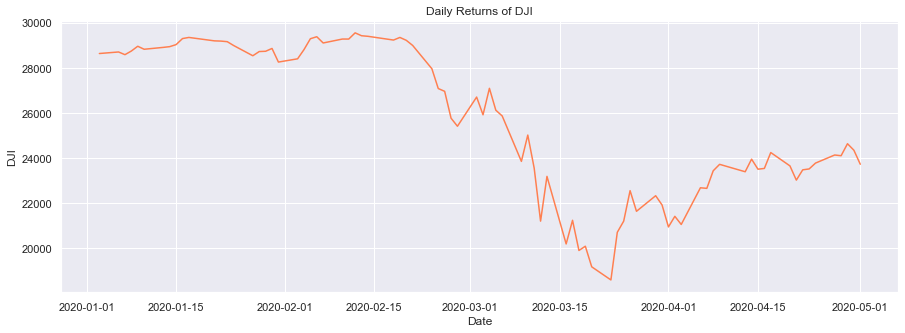

In [7]:
# The ticker we analyze for all the following parts : Dow Jones Industrial Average
ticker = 'DJI'

#*********************************************************************************

fig, ax = plt.subplots(1, figsize=(15,5))

# Plot the daily returns of the index
ax =  sns.lineplot(x="Date", y=ticker,
             data=stocks, color='coral')
ax.set_title('Daily Returns of ' + ticker)
plt.savefig("DJI_daily_ret.png")
plt.show()

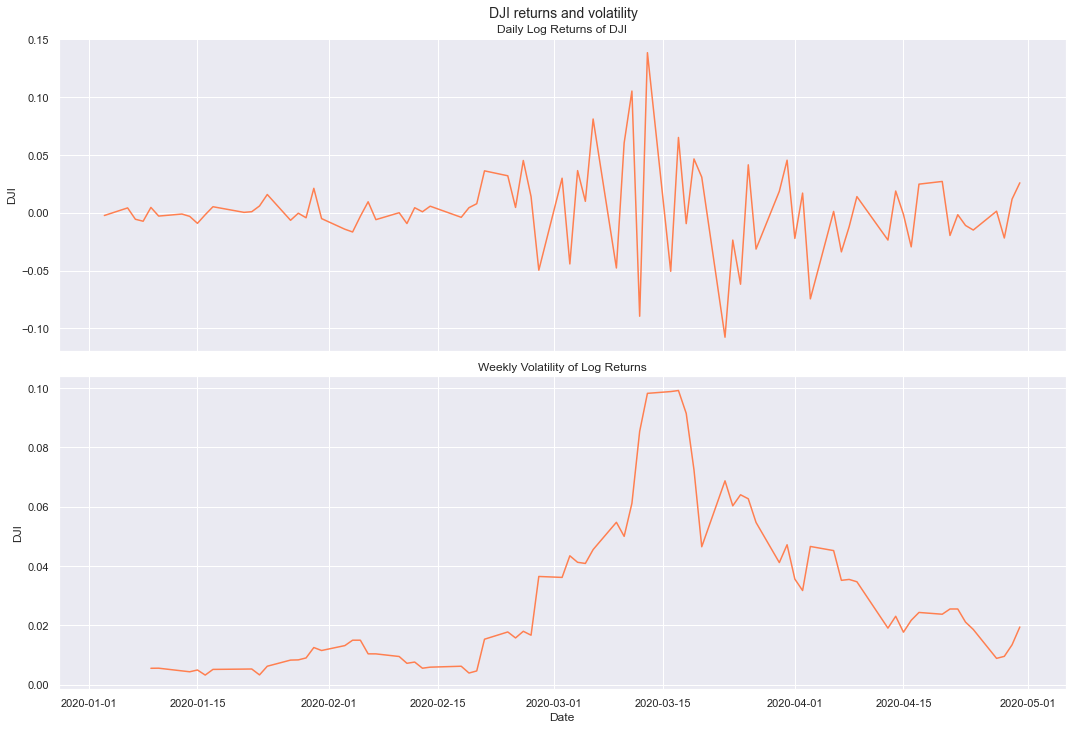

In [8]:
fig, ax = plt.subplots(2,1, figsize=(15,10),sharex=True)

plt.figtext(0.525, 1, ticker+" returns and volatility",fontsize=14, ha='center', va='center')

# Plot the log returns of the index
ax[0] =  sns.lineplot(x="Date", y=ticker,
             data=daily_returns, color='coral', ax=ax[0])
ax[0].set_title('Daily Log Returns of ' + ticker)

# Plot the weeekly volatility returns of the index
ax[1] =  sns.lineplot(x="Date", y=ticker,
             data=weekly_volatility, color='coral', ax=ax[1])
ax[1].set_title('Weekly Volatility of Log Returns')
plt.tight_layout()
plt.savefig("Daily_log_ret+volatility.png")
plt.show()

In [9]:
# Computing weekly volatility for the stocks
stocks_weekly_volatility = stocks.rolling(5).std()
stocks_weekly_volatility = stocks_weekly_volatility.set_index(stocks['Date']).dropna()

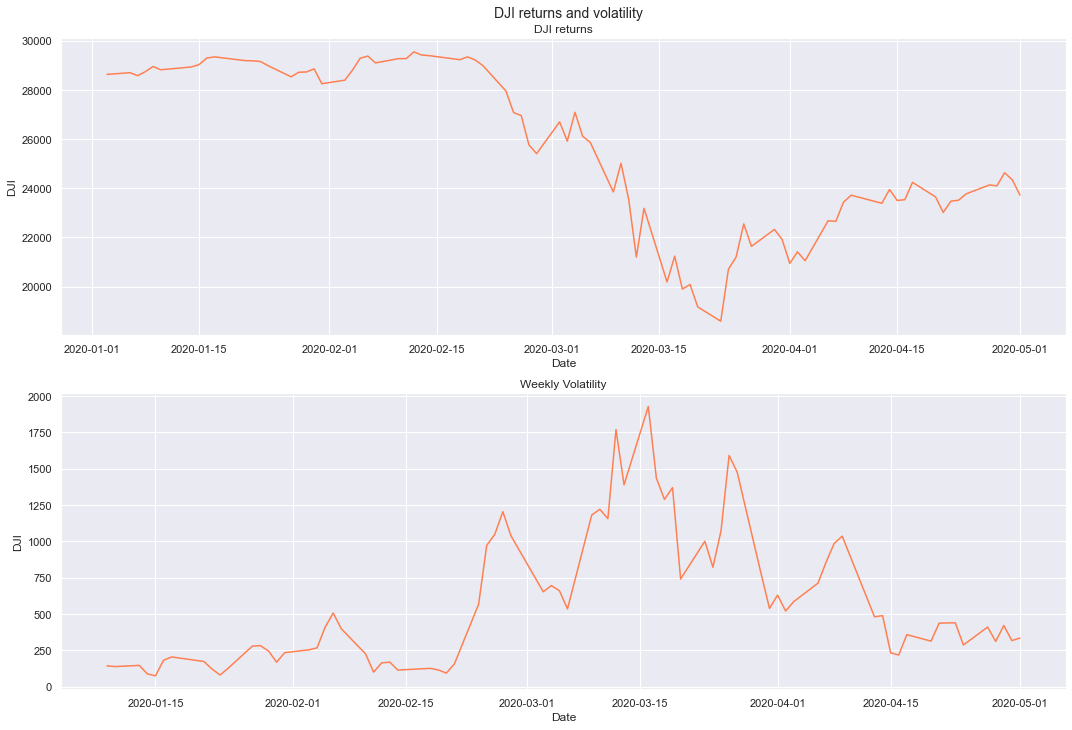

In [10]:
fig, ax = plt.subplots(2,1, figsize=(15,10))

# Plot the log returns of the index

plt.figtext(0.53, 1, ticker+" returns and volatility",fontsize=14, ha='center', va='center')

ax[0] =  sns.lineplot(x="Date", y=ticker,
             data=stocks, color='coral', ax=ax[0])
plt.subplots_adjust(hspace=0.5)
ax[0].set_title(ticker+" returns")

ax[1] =  sns.lineplot(x="Date", y=ticker,
             data=stocks_weekly_volatility, color='coral', ax=ax[1])
ax[1].set_title('Weekly Volatility')
fig.savefig("DJI_Returns_Volatility.png")
fig.tight_layout()
plt.show()

---
For this project, we will model the daily log returns of DJI. This is usualy done because this transformation helps the data fitting in the ARMA and GARCH models (explained later) and because many assumptions in quantitive finance are based on the fact that stocks follow some modified version of a Brownian Process which leads to the log returns of a stock follows a Normal Distribution (this is a very quick and simplified idea but explains our choice).

---

## Base Model Selection

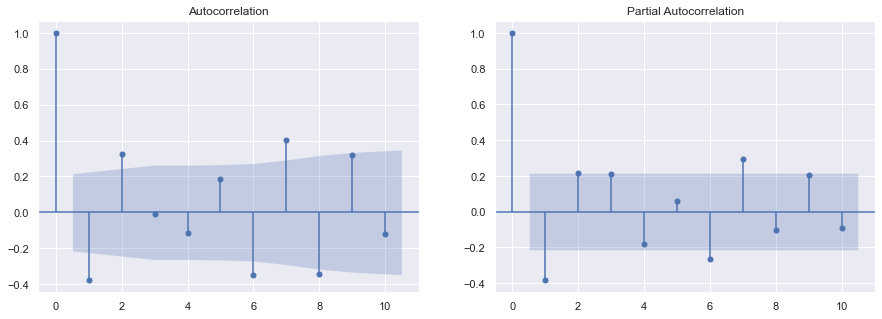

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

returns = daily_returns[['Date',ticker]].dropna()

# Some analysis for model selection (which lags seem important) => only lag 1,2 at most
fig, ax = plt.subplots(1,2, figsize=(15,5))
plot_acf(returns[ticker], lags=10, ax=ax[0])
plot_pacf(returns[ticker], lags=10, ax=ax[1])
plt.show()

In [12]:
from arch import arch_model

### The package "arch" :
This is an important package we use in all the following parts to model the data. It contains useful models and forecasts for financial time series.

What arch does and how we can use it for this project :

- mean : give a mean model - ARX is AR with exogenous
- vol : give a volatility model
- x : exogenous predictors (which is google trends for the next part)
- lags : for mean ARX
- p,o,q : GARCH parameters
- dist : distribution of residuals

### Model formula : GARCH(1,1) with zero mean and Student's t distributed errors
- $ \normalsize r_t  =  0 + \epsilon_t $
- $ \normalsize \sigma^2_t   =  \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2 $
- $ \normalsize \epsilon_t  =  \sigma_t e_t,\,\,\, e_t  \sim  t_{\nu} $

In [13]:
# First model : GARCH 
# We multiplied by scale=10 for scaling requirements by the arch package but we rescale after in the forecast
arch_res = arch_model(10*returns[ticker], mean='Zero', vol='GARCH', p=1, o=0, q=1, dist='StudentsT').fit(disp='off')
print(arch_res.summary())

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                          DJI   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.012
Vol Model:                            GARCH   Log-Likelihood:                4.39503
Distribution:      Standardized Student's t   AIC:                         -0.790064
Method:                  Maximum Likelihood   BIC:                           8.83681
                                              No. Observations:                   82
Date:                      Thu, Dec 17 2020   Df Residuals:                       78
Time:                              19:59:56   Df Model:                            4
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
o

In [14]:
# Predicting variance (we need to rescale divide by scale^2 = 100)
variance_forecasts = arch_res.forecast(horizon=1, start=0).variance/100

# Predicted volatility
weekly_std_forecast = np.sqrt(variance_forecasts.rolling(5).mean())

In [15]:
#Creating a dataframe containing our weekly_volatility estimates and the model's prediction
weekly_volatility_prediction = weekly_std_forecast.dropna().set_index(weekly_volatility[ticker].index)
weekly_volatility_prediction = weekly_volatility_prediction.join(weekly_volatility[ticker]).rename(columns={'h.1':'Prediction'})

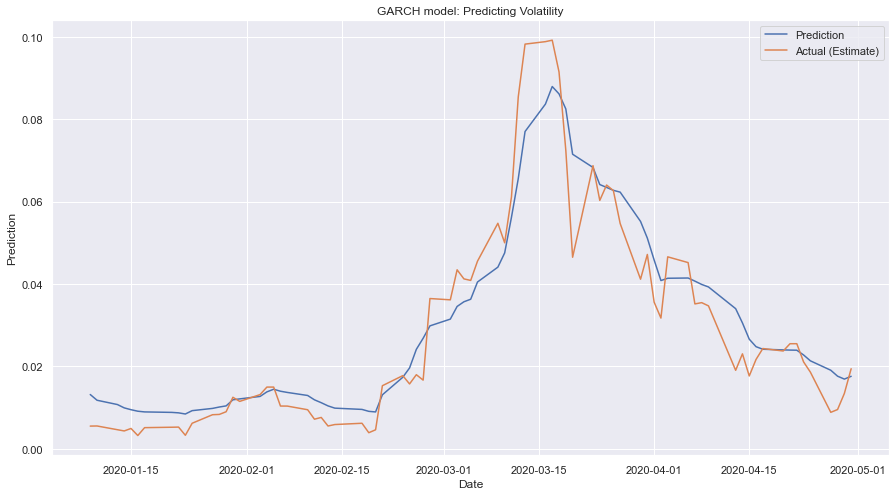

In [16]:
# Plot
fig, ax = plt.subplots(1, figsize=(15,8))

ax = sns.lineplot(x="Date",y="Prediction",
            data=weekly_volatility_prediction, label='Prediction', ax=ax)

ax = sns.lineplot(x="Date",y=ticker,
            data=weekly_volatility_prediction, label='Actual (Estimate)',ax=ax)

ax.set_title('GARCH model: Predicting Volatility')
plt.savefig("Basemodel.png")
plt.show()

---

## Google Trends data using Pytrends:

### Importing the data:
- We wills use the package [pytrends](https://pypi.org/project/pytrends/) to get the relevant google trends data given a list of search keywords.

In [17]:
from pytrends.request import TrendReq
from pytrends import dailydata

import time

def GetTrends(keywords, start_date, end_date):
    """
    returns the Google trends data (weekly and daily)
    
    :param keywords: the list of the keywords to search data for
    :param start_date: string of start_date. (Y-M-D format)
    :param end_date: string of end_date. (Y-M-D format)
    
    """
    
    startTime = time.time()
    
    timeframe = start_date +' '+ end_date
    
    start_date = datetime.date(datetime.strptime(start_date,"%Y-%m-%d"))
    end_date = datetime.date(datetime.strptime(end_date,"%Y-%m-%d"))

    start_year, start_month = start_date.year, start_date.month
    stop_year, stop_month = end_date.year, end_date.month
    
    # Connect to google trends
    # hl: host language (English)
    # timezone offset=360 (US CST)
    pytrends = TrendReq(hl='en-US', tz=360)

    # keywords list kw_list

    weekly_dataset = []
    
    daily_data = pd.DataFrame(columns=keywords)
    weekly_data = pd.DataFrame(columns=keywords)

    for keyword in keywords:
        
        # build payload for pytrends
        pytrends.build_payload(
        kw_list=[keyword],
        timeframe = timeframe)
        
        # get weekly data
        tmp_data = pytrends.interest_over_time()
        
        if not tmp_data.empty:
            weekly_data[keyword] = tmp_data[keyword]
            
        # get daily data
        col_name = keyword+"_unscaled"
        tmp_data = dailydata.get_daily_data(keyword,
                                              start_year,
                                              start_month,
                                              stop_year,
                                              stop_month,
                                              geo='US',
                                              verbose=False)[col_name]
        
        if not tmp_data.empty:
            daily_data[keyword] = tmp_data

    executionTime = (time.time() - startTime)
    print('Execution time in sec.: ' + str(executionTime))

        
    print("Google Trends data download success.")
    
    return weekly_data, daily_data

---
Now, we chose keywords that are related to finance and in particular financial crisis. We had a long list, as you can see in the next cell, but we kept only four for these reasons :
- We kept only the keyword that had a spike just before or during the crisis.
- From this list, we kept only the significant ones after fitting the trends model.
- We wanted the model to be simple and quick to fit and predict as in the paper.

---

In [18]:
# List of possible keywords
keywords = ['debt','loan','job','unemployment','economics','inflation','sell','bonds','gold','stocks','dow jones', \
            'crisis','finance','risk','leverage']

keywords = ['unemployment','stocks','crisis','dow jones']

# Data already saved but here is how we got it
if(False):
    g_trends_weekly, g_trends_daily = GetTrends(keywords, start_date, end_date)
    SaveData(g_trends_weekly, 'weekly_google_trends')
    SaveData(g_trends_daily, 'daily_google_trends')
else:
    g_trends_daily = pd.read_csv('data/daily_google_trends.csv')
    g_trends_daily.set_index(g_trends_daily.date.astype('datetime64[ns]'), inplace=True)
    g_trends_daily.drop('date', axis=1, inplace=True)

In [19]:
g_trends_daily

,unemployment,stocks,crisis,dow jones
date,,,,
2020-01-01,38,51,21,20
2020-01-02,70,85,30,74
2020-01-03,66,100,34,92
2020-01-04,38,69,32,17
2020-01-05,74,56,29,6
...,...,...,...,...
2020-05-27,80,88,100,98
2020-05-28,66,92,92,97
2020-05-29,57,74,80,88


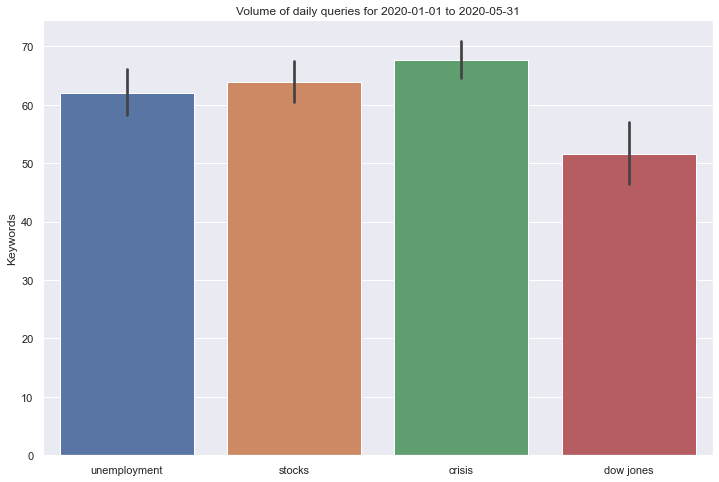

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(data=g_trends_daily)
ax.set_title("Volume of daily queries for 2020-01-01 to 2020-05-31")
ax.set_ylabel("Queries volume")
ax.set_ylabel("Keywords")
plt.savefig("queriesmeans.png")
plt.show()

In [21]:
from statsmodels.tsa.seasonal import STL

# Creating non-seasonal time series for the Google queries 
# It actually improves the convergence of optimizer when fitting the model

for keyword in keywords:
    g_trends_daily[keyword+'.nsa'] = g_trends_daily[keyword] - STL(g_trends_daily[keyword]).fit().seasonal
    
g_trends_daily

,unemployment,stocks,crisis,dow jones,unemployment.nsa,stocks.nsa,crisis.nsa,dow jones.nsa
date,,,,,,,,
2020-01-01,38,51,21,20,56.609303,61.085039,13.503984,22.151593
2020-01-02,70,85,30,74,69.564646,75.938709,27.519270,48.544424
2020-01-03,66,100,34,92,67.591305,83.159644,32.285541,56.735440
2020-01-04,38,69,32,17,68.699494,78.764815,37.609384,56.165219
2020-01-05,74,56,29,6,70.281637,77.030506,39.211897,58.770519
...,...,...,...,...,...,...,...,...
2020-05-27,80,88,100,98,71.142435,71.382745,90.803262,63.113949
2020-05-28,66,92,92,97,67.001982,73.114032,85.574513,61.466983
2020-05-29,57,74,80,88,69.049321,71.226393,82.558901,65.866208


---
First, we plot the non-seasonal time series for each keyword to visualize clear spikes juste before march. Then, we plot only their trends and the DJI log returns. We can clearly see the volatility increases just after the spikes in volume of queries for "crisis", "dow jones" and "stocks". Nice!

---

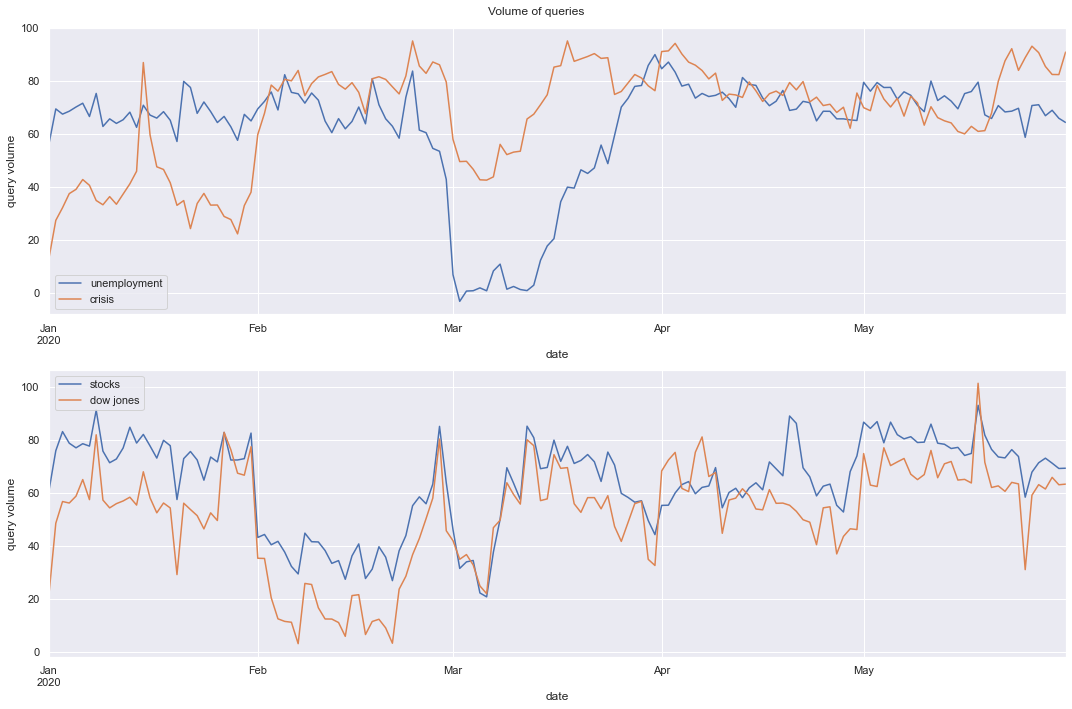

In [22]:
# Visualizing the non seasonal Google queries 
fig, axs = plt.subplots(2,figsize=(15,10))

for ind, keyword in enumerate(keywords):
    if ind % 2 == 0:
        g_trends_daily[keyword+'.nsa'].plot(ax=axs[0], label=keyword)
        axs[0].legend(loc='best')
        axs[0].set_ylabel("query volume")
    else:
        g_trends_daily[keyword+'.nsa'].plot(ax=axs[1], label=keyword)
        axs[1].legend(loc='best')
        axs[1].set_ylabel("query volume")
        
fig.suptitle("Volume of queries")
fig.tight_layout()
plt.savefig("volumeofqueries.png")
plt.show()

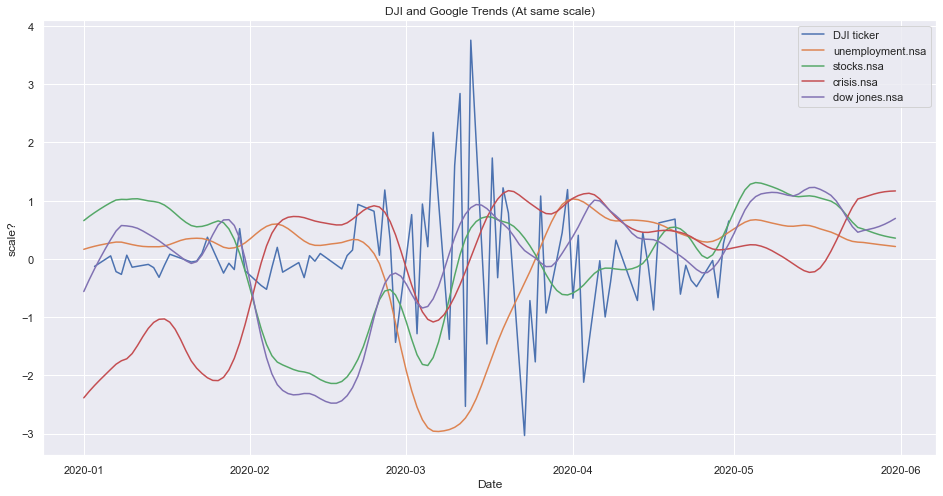

In [23]:
from sklearn.preprocessing import scale

# Visualizing queries trend and ticker log returns at the same scale
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(ticker + ' and Google Trends (At same scale)')
ax.plot(returns['Date'], scale(returns[ticker]), label=ticker+' ticker')
for keyword in keywords:
    trend = STL(g_trends_daily[keyword]).fit().trend
    ax.plot(g_trends_daily.index, scale(trend), label=keyword+'.nsa')
ax.legend(loc='best')
ax.set_xlabel('Date')
ax.set_ylabel('scale?') # to change
plt.savefig("Trends+DJI.png")
plt.show()

---

## Trends Model Selection

### Model formula : GARCH(1,1) with  linear exogenous mean and Student's t distributed errors
- $ \normalsize r_t  =  \mu + \text{dow jones.nsa}_t + \text{crisis.nsa}_t + \epsilon_t $
- $ \normalsize \sigma^2_t   =  \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2 $
- $ \normalsize \epsilon_t  =  \sigma_t e_t,\,\,\, e_t  \sim  t_{\nu} $

In [24]:
# After some testing the most significant are crisis and dow jones queries
arch_trends_res = arch_model(10*returns[ticker], 
                             mean='ARX', x=g_trends_daily[['dow jones.nsa','crisis.nsa']].loc[returns['Date']], 
                             vol='GARCH', p=1, o=0, q=1, dist='StudentsT').fit(disp='off')
print(arch_trends_res.summary())

                             AR-X - GARCH Model Results                             
Dep. Variable:                          DJI   R-squared:                       0.012
Mean Model:                            AR-X   Adj. R-squared:                 -0.013
Vol Model:                            GARCH   Log-Likelihood:                7.83264
Distribution:      Standardized Student's t   AIC:                          -1.66528
Method:                  Maximum Likelihood   BIC:                           15.1818
                                              No. Observations:                   82
Date:                      Thu, Dec 17 2020   Df Residuals:                       75
Time:                              20:00:00   Df Model:                            7
                                    Mean Model                                    
                     coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------

In [25]:
# Predicting variance
variance_forecasts_trends = arch_trends_res.forecast(horizon=1, start=0).variance/100

# Predicted volatility
weekly_std_trends_forecast = np.sqrt(variance_forecasts_trends.rolling(5).mean())

In [29]:
#Creating a dataframe containing our weekly_volatility estimates and the model's prediction
weekly_volatility_prediction = weekly_std_trends_forecast.dropna().set_index(weekly_volatility[ticker].index)
weekly_volatility_prediction = weekly_volatility_prediction.join(weekly_volatility[ticker]).rename(columns={'h.1':'Prediction'})

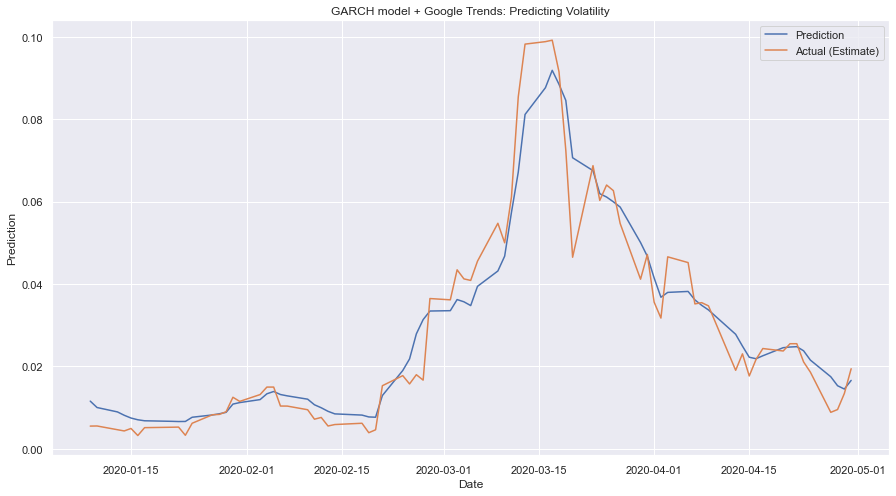

In [30]:
# Plot
fig, ax = plt.subplots(1, figsize=(15,8))

ax = sns.lineplot(x="Date",y="Prediction",
            data=weekly_volatility_prediction, label='Prediction', ax=ax)

ax = sns.lineplot(x="Date",y=ticker,
            data=weekly_volatility_prediction, label='Actual (Estimate)',ax=ax)

ax.set_title('GARCH model + Google Trends: Predicting Volatility')
plt.savefig("trendsmodel.png")
plt.show()

---

## Comparing Models

In [28]:
from sklearn.metrics import mean_absolute_error

mae_base   = mean_absolute_error(weekly_volatility[ticker].dropna(), weekly_std_forecast.dropna());
mae_trends = mean_absolute_error(weekly_volatility[ticker].dropna(), weekly_std_trends_forecast.dropna());

print('MAE base = %.4f - MAE trends = %.4f - Improvement = %.2f %%' % (mae_base,mae_trends,100*(1-mae_trends/mae_base)))

MAE base = 0.0055 - MAE trends = 0.0044 - Improvement = 20.38 %


---

## Predicting the 2020 stock market crash

In [54]:
# The market crash started the 20 February 2020 and ended on 7 April.

# 2020-01-03 -> 2020-02-19
train = returns.loc[:32]

# 2020-02-20 -> 2020-04-07
test  = returns.loc[33:66]

<AxesSubplot:>

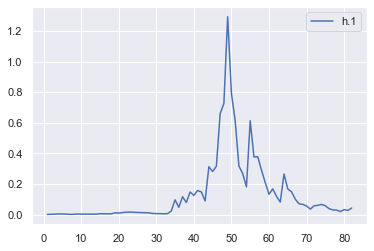

In [31]:
# Rolling Window Forecast
scale = 100
am = arch_model(scale*returns[ticker], mean='Zero', vol='GARCH', p=1, o=0, q=1, dist='StudentsT')
index = returns.Date
start_loc = 0
end_loc = returns['Date'].size
forecasts = {}
for i in range(end_loc):
    res = am.fit(first_obs=0, last_obs=i+1, disp='off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i]
    forecasts[fcast.name] = fcast/(scale^2)

pd.DataFrame(forecasts).T.plot()

---

# Conclusion

# -_________-

### WHAT NEEDS TO BE DONE :
### Do the same thing I did for base and trends model but using rolling window with one step ahead prediction and then compute the MAEs
### OR
### training set before drop and the rest for testing and see how it performs during the drop